# UVA-Morven sandbox

## First step: loading dependencies and helper functions

In [1]:
#
# When running for the first time, install dependencies:
#!pip install numpy matplotlib pandas seaborn h5pyd
#
# Then, load the required modules
#
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import datetime
import h5pyd
import time

In [2]:
#
# Settings for plotting graphs
#
%matplotlib inline
#
# Determine graph size
sns.set(rc={'figure.figsize':(18, 8)})

In [3]:
#
# Load the complete datastore from HSDS
# In this example, all the data generated from UVA Morven
# From October 1, 2020 until February 28, 2022
#
filepath = "hdf5://home/uva-morven.h5"

In [4]:
#
# Open HSDS datastore as 'f'
#
# Please note: 
# Set use_cache to False to pick up any real time changes
# This is useful if the analyst wants to include latest data batch
#
f = h5pyd.File(filepath, mode='r', use_cache=True)

In [5]:
#
# Useful functions:
# Show HDF5 attributes
#
def read_attrs(obj):
    for k in obj.attrs:
        v = obj.attrs[k]
        print(f"{k}: {v}")
        
#
# Convert timestamp (ts) in seconds to a date-time string
# Note: in the database, all datetime is stored in seconds 
#
def ts_to_str(ts):
    value = datetime.datetime.fromtimestamp(ts)
    s = value.isoformat(sep=' ', timespec='seconds')
    return s

#
# Convert np bytestring values to string
# to make things easier when working with dataframes
# 
def convert_bytestr_to_str(df):
    df_converted = df
    for col, dtype in df.dtypes.items():
        if dtype == object:
            df[col] = df[col].str.decode('utf-8')
    return df_converted

## Loggers table

In [6]:
#
# Read loggers / stations
#
loggers = f["loggers"]

#
# Display logger name, number, and last time they were updated
#
for i in range(loggers.nrows):
    row = loggers[i]
    logger_name = row['name'].decode('utf-8')
    logger_sn = row['sn'].decode('utf-8')
    last_query_ts = row['last_query']
    last_query_datestr = ts_to_str(last_query_ts)
    print(f"name: {logger_name}, logger number: {logger_sn}, last time updated: {last_query_datestr}")

# 
# Create a varible w/ logger names to use in this notebook:
# So we can avoid having to call stations / loggers by serial number
#
HOBO1 = loggers[0]['sn'].decode('utf-8')
HOBO2 = loggers[1]['sn'].decode('utf-8')

name: HOBO1, logger number: 20778368, last time updated: 2022-02-28 18:59:59
name: HOBO2, logger number: 20778369, last time updated: 2022-02-28 18:59:59


In [7]:
#
# Display name in Iñupiaq and location, GPS coordinates
# 
for i in range(loggers.nrows):
    # read database row w/ individual logger info
    row = loggers[i]
    #
    # Read individual fields per row of the db
    #
    # Note: Always use .decode('utf-8') for text...
    # because values are saved in binary, not text
    # to speed things up!
    #
    logger_ipk_name = row['name_ipk'].decode('utf-8')
    logger_address = row['location_en'].decode('utf-8')
    logger_address_ipk = row['location_ipk'].decode('utf-8')
    gps_lat = row['lat']
    gps_lon = row['lon']

    # Generate pretty output:
    print(f"Name in Iñupiaq: {logger_ipk_name}\n"        
          f"Address: {logger_address}\n"                 
          f"Address in Iñupiaq: {logger_address_ipk}\n"  
          f"Lat: {gps_lat}\n"                            
          f"Long: {gps_lon}\n")

Name in Iñupiaq: HOBO1
Address: 120 Nanook road, Utkiagviq, AK
Address in Iñupiaq: Nanook's den
Lat: 38.042999267578125
Long: 78.56210327148438

Name in Iñupiaq: HOBO2
Address: 150 Inupiaq road, Uktiagviq, AK
Address in Iñupiaq: Inupiat way
Lat: 34.04309844970703
Long: 74.56210327148438



In [8]:
#
# OK, this is fun, but not particularly useful...
# How about having it all organized in a tabular form?
# It only takes a few lines!
#
# First read the loggers database from the HDF store
loggers = f['loggers']

# Then, convert the database into an array...
# so it can be converted finally to a dataframe:
arr = loggers.value
df = pd.DataFrame(arr)
for col, dtype in df.dtypes.items():
    if dtype == object:
       df[col] = df[col].str.decode('utf-8')

# Now we can display the DF in its full glory:
df_loggers = df
df_loggers

sn  schema_version  active   name name_ipk            model  \
0  20778368             0.1       1  HOBO1    HOBO1  HOBOLink RX3000   
1  20778369             0.1       1  HOBO2    HOBO2  HOBOLink RX3000   

                       location_en  location_ipk        lat      lat_units  \
0   120 Nanook road, Utkiagviq, AK  Nanook's den  38.042999  degrees_north   
1  150 Inupiaq road, Uktiagviq, AK   Inupiat way  34.043098  degrees_north   

         lon     lon_units  height height_units  altitude altitude_units  \
0  78.562103  degrees_east     3.0            m       3.0              m   
1  74.562103  degrees_east     3.0            m       3.0              m   

   battery_level_max  battery_level_min battery_units  last_query  
0                4.2                3.0             V  1646092799  
1                4.2                3.0             V  1646092799

## Sensors table

In [9]:
#
# First, read the sensors database from the HDF store
#
sensors = f['sensors']

# Then, convert the database into an array...
# so it can be converted finally to a dataframe:
arr = sensors.value
df = pd.DataFrame(arr)

#
# Now we can display the DF in its full glory
# But limit to list only the first 10 sensors
# 
# Note: convert the np bytestrings to str
#
df_sensors = convert_bytestr_to_str(df)
df_sensors

sn  sn_logger  schema_version  active          long_name  \
0   20748043-1   20778369             0.1       1    Solar Radiation   
1   20770090-1   20778369             0.1       1   Soil Temperature   
2   20770097-1  207783678             0.1       1   Soil Temperature   
3   20773519-1   20778368             0.1       1      Water Content   
4   20773520-1   20778369             0.1       1      Water Content   
5   20774022-1   20778369             0.1       1     Wind Direction   
6   20774023-1   20778368             0.1       1     Wind Direction   
7   20774025-1   20778369             0.1       1     Wind Direction   
8   20775976-1   20778368             0.1       1               Rain   
9   20775977-1   20778369             0.1       1               Rain   
10  20776844-1   20778369             0.1       1   Soil Temperature   
11  20777744-1   20778368             0.1       1        Temperature   
12  20777745-1   20778369             0.1       1        Temperature   
13  20777747-1   20778369             0.1       1        Temperature   
14  20777747-2   20778368             0.1       1  Relative Humidity   
15  20778345-1   20778369             0.1       1      Water Content   
16  20778347-1   20778369             0.1       1      Water Content   
17  20779613-1   20778369             0.1       1    Solar Radiation   
18  20779623-1   20778369             0.1       1         Wind Speed   
19  20779623-2   20778369             0.1       1         Gust Speed   
20  20779623-3   20778369             0.1       1     Wind Direction   
21  20779631-1   20778369             0.1       1         Wind Speed   
22  20779631-2   20778369             0.1       1         Gust Speed   
23  20779631-3   20778369             0.1       1     Wind Direction   
24  20779676-1   20778368             0.1       1    Solar Radiation   
25  20779912-1   20778369             0.1       1         Wind Speed   
26  20779912-2   20778369             0.1       1         Gust Speed   
27  20779920-1   20778368             0.1       1         Wind Speed   
28  20779920-2   20778368             0.1       1         Gust Speed   
29  20779922-1   20778369             0.1       1         Wind Speed   
30  20779922-2   20778369             0.1       1         Gust Speed   
31  20780853-1   20778369             0.1       1        Temperature   
32  20780853-2   20778368             0.1       1  Relative Humidity   
33  20780855-1   20778369             0.1       1        Temperature   
34  20780855-2   20778368             0.1       1  Relative Humidity   
35  20783591-1   20778369             0.1       1   Soil Temperature   

                                       standard_name  \
0                                   solar_irradiance   
1                                   soil_temperature   
2                                   soil_temperature   
3   mass_fraction_of_unfrozen_water_in_soil_moisture   
4   mass_fraction_of_unfrozen_water_in_soil_moisture   
5                                wind_from_direction   
6                                wind_from_direction   
7                                wind_from_direction   
8                       thickness_of_rainfall_amount   
9                       thickness_of_rainfall_amount   
10                                  soil_temperature   
11                                   air_temperature   
12                                   air_temperature   
13                                   air_temperature   
14                                 relative_humidity   
15  mass_fraction_of_unfrozen_water_in_soil_moisture   
16  mass_fraction_of_unfrozen_water_in_soil_moisture   
17                                  solar_irradiance   
18                                        wind_speed   
19                                wind_speed_of_gust   
20                               wind_from_direction   
21                                        wind_speed   
22                                wind_speed_of_gust   
23 

In [10]:
#
# OK, let's list all the sensors per station
# First for HOBO1
#
df_result = df_sensors.loc[(df_sensors['sn_logger'] == HOBO1)]
df_result = pd.concat([df_result['sn'], df_result['standard_name']], axis=1)
df_result

sn                                     standard_name
3   20773519-1  mass_fraction_of_unfrozen_water_in_soil_moisture
6   20774023-1                               wind_from_direction
8   20775976-1                      thickness_of_rainfall_amount
11  20777744-1                                   air_temperature
14  20777747-2                                 relative_humidity
24  20779676-1                                  solar_irradiance
27  20779920-1                                        wind_speed
28  20779920-2                                wind_speed_of_gust
32  20780853-2                                 relative_humidity
34  20780855-2                                 relative_humidity

In [11]:
#
# How about station 2?
# Call it by name: HOBO2:
# Neat!
#
df_result = df_sensors.loc[(df_sensors['sn_logger'] == HOBO2)]
df_result

sn sn_logger  schema_version  active         long_name  \
0   20748043-1  20778369             0.1       1   Solar Radiation   
1   20770090-1  20778369             0.1       1  Soil Temperature   
4   20773520-1  20778369             0.1       1     Water Content   
5   20774022-1  20778369             0.1       1    Wind Direction   
7   20774025-1  20778369             0.1       1    Wind Direction   
9   20775977-1  20778369             0.1       1              Rain   
10  20776844-1  20778369             0.1       1  Soil Temperature   
12  20777745-1  20778369             0.1       1       Temperature   
13  20777747-1  20778369             0.1       1       Temperature   
15  20778345-1  20778369             0.1       1     Water Content   
16  20778347-1  20778369             0.1       1     Water Content   
17  20779613-1  20778369             0.1       1   Solar Radiation   
18  20779623-1  20778369             0.1       1        Wind Speed   
19  20779623-2  20778369             0.1       1        Gust Speed   
20  20779623-3  20778369             0.1       1    Wind Direction   
21  20779631-1  20778369             0.1       1        Wind Speed   
22  20779631-2  20778369             0.1       1        Gust Speed   
23  20779631-3  20778369             0.1       1    Wind Direction   
25  20779912-1  20778369             0.1       1        Wind Speed   
26  20779912-2  20778369             0.1       1        Gust Speed   
29  20779922-1  20778369             0.1       1        Wind Speed   
30  20779922-2  20778369             0.1       1        Gust Speed   
31  20780853-1  20778369             0.1       1       Temperature   
33  20780855-1  20778369             0.1       1       Temperature   
35  20783591-1  20778369             0.1       1  Soil Temperature   

                                       standard_name  \
0                                   solar_irradiance   
1                                   soil_temperature   
4   mass_fraction_of_unfrozen_water_in_soil_moisture   
5                                wind_from_direction   
7                                wind_from_direction   
9                       thickness_of_rainfall_amount   
10                                  soil_temperature   
12                                   air_temperature   
13                                   air_temperature   
15  mass_fraction_of_unfrozen_water_in_soil_moisture   
16  mass_fraction_of_unfrozen_water_in_soil_moisture   
17                                  solar_irradiance   
18                                        wind_speed   
19                                wind_speed_of_gust   
20                               wind_from_direction   
21                                        wind_speed   
22                                wind_speed_of_gust   
23                               wind_from_direction   
25                                        wind_speed   
26                                wind_speed_of_gust   
29                                        wind_speed   
30                                wind_speed_of_gust   
31                                   air_temperature   
33                                   air_temperature   
35                                  soil_temperature   

                  sensor_type            model        lat      lat_units  ...  \
0                                               37.965302  degrees_north  ...   
1                                               37.965302  degrees_north  ...   
4                                         HOBO  37.965302  degrees_north  ...   
5                                         HOBO  37.965302  degrees_north  ...   
7                                         HOBO  37.965302  degrees_north  ...   
9                                         HOBO  37.965302  degrees_north  ...   
10                                              37.965302  degrees_north  ...   
12  12-bit temperature sensor  HOBO S-THB-M002  37.965302  degrees_north  ...   
13  1

In [12]:
# 
# What if we want all the sensors of one type, for just one station?
# Here is an example: create table for all the 'relative_humidity' for HOBO1
# Output a list of sensors to be used anywhere you want!
#
df_result = df_sensors.loc[(df_sensors['sn_logger'] == HOBO1) 
                           & (df_sensors['standard_name'] == 'relative_humidity')] 
sensors_humidity = df_result['sn'].values
print(sensors_humidity)

['20777747-2' '20780853-2' '20780855-2']


## Data table

In [13]:
# 
# Reading sensor data
# Now that we can get all the relevant info about the stations + sensors
# First, let's read the dataset and pass to a variable called 'data'
# 
data_table = f['data']

# Let's see the dimensions of the dataset
# UVA Morven has 22.5M data points
data_table

<HDF5 dataset "data": shape (22516484,), type "|V48">

In [14]:
#
# Now, we need to convert from numpy array to Pandas dataframe
# That is much easier to manipulate, plot, etc.
#
# Note:
# Using "%time" before any instruction tells us the time spent
# In this case, 2 seconds to read the table w/ 22.5M datapoints
# and organize it into a Pandas dataframe, not too bad...
# 
arr = data_table.value
%time df = pd.DataFrame(arr)

CPU times: user 1.17 s, sys: 499 ms, total: 1.67 s
Wall time: 1.67 s


In [15]:
%%time
#
# Look into the dataframe, just the first 10 lines!
# This operation is aesthetic and takes a bit of time,
# because it traverses the df to convert the strings...
# each bytestr (from numpy format) into regular Python str
#
# Aesthetics matters... for the modic wait of 18 seconds
# 
df = convert_bytestr_to_str(df)
df[:10]

CPU times: user 13 s, sys: 1.18 s, total: 14.1 s
Wall time: 19.5 s


logger_sn   sensor_sn  data_type_id  measurement_type   si_value   timestamp
0  20778368  20775976-1             1                 5   0.000000  1601524800
1  20778368  20777744-2             1                 2  79.399996  1601524800
2  20778368  20777744-3             1                 6  11.231701  1601524800
3  20778368  20778368-B             1                13   4.219672  1601524800
4  20778368  20779676-1             1                 3   0.625000  1601524800
5  20778368  20779920-2             1                10   0.000000  1601524800
6  20778368  20780855-1             1                 1  19.280952  1601524800
7  20778368  20780855-2             1                 2  71.996643  1601524800
8  20778368  20780855-3             1                 6  14.126852  1601524800
9  20778368  20780855-B             1                12  66.000000  1601524800

## Timestamp conversion

In [16]:
%%time
#
# Convert the time coordinate (in seconds, Unix epoch) to datetime
# Now we can work happily with normal date-time, not seconds:
# Computationally intensive, takes 13 seconds
#
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', utc=True)
df = df.set_index('timestamp')

CPU times: user 1.47 s, sys: 593 ms, total: 2.06 s
Wall time: 4.27 s


In [17]:
%%time
#
# Slice the dataframe as needed: for instance:
# By specifying the time interval (in UTC)
# 
# Let's start with the first month in the Morven dataset:
# October 1, 2020 --> until --> October 31, 2020
# We can include hour:minute:second precision, if needed
# 
df_oct_2020 = df.loc['2020-10-01 00:00:00':'2020-10-31 23:59:59']
df_oct_2020

CPU times: user 341 ms, sys: 55.5 ms, total: 397 ms
Wall time: 7.66 s


<timed exec>:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2020-10-01 04:00:00+00:00  20778368  20775976-1             1   
2020-10-01 04:00:00+00:00  20778368  20777744-2             1   
2020-10-01 04:00:00+00:00  20778368  20777744-3             1   
2020-10-01 04:00:00+00:00  20778368  20778368-B             1   
2020-10-01 04:00:00+00:00  20778368  20779676-1             1   
...                             ...         ...           ...   
2020-10-31 23:55:00+00:00  20778369  20777747-3             1   
2020-10-31 23:55:00+00:00  20778369  20779674-1             1   
2020-10-31 23:55:00+00:00  20778369  20779912-1             1   
2020-10-31 23:55:00+00:00  20778369  20779912-2             1   
2020-10-31 23:55:02+00:00  20778369  20778369-B             1   

                           measurement_type    si_value  
timestamp                                                
2020-10-01 04:00:00+00:00                 5    0.000000  
2020-10-01 04:00:00+00:00                 2   79.399996  
2020-10-01 04:00:00+00:00                 6   11.231701  
2020-10-01 04:00:00+00:00                13    4.219672  
2020-10-01 04:00:00+00:00                 3    0.625000  
...                                     ...         ...  
2020-10-31 23:55:00+00:00                 6    2.986177  
2020-10-31 23:55:00+00:00                 3  120.625000  
2020-10-31 23:55:00+00:00                 9    0.000000  
2020-10-31 23:55:00+00:00                10    1.006541  
2020-10-31 23:55:02+00:00                11    4.300820  

[930215 rows x 5 columns]

In [18]:
%%time
#
# We may want to only select 'humidity sensors' in October
# Let's generate a 'sensor_lst' (list)
# And then select the slice with the .isin() method:
#
df_oct_hum_sense = df_oct_2020.loc[df_oct_2020['sensor_sn'].isin(sensors_humidity)]
df_oct_hum_sense

CPU times: user 56.3 ms, sys: 35 µs, total: 56.4 ms
Wall time: 80.3 ms


logger_sn   sensor_sn  data_type_id  \
timestamp                                                       
2020-10-01 04:00:00+00:00  20778368  20780855-2             1   
2020-10-01 04:05:00+00:00  20778368  20780855-2             1   
2020-10-01 04:10:00+00:00  20778368  20780855-2             1   
2020-10-01 04:15:00+00:00  20778368  20780855-2             1   
2020-10-01 04:20:00+00:00  20778368  20780855-2             1   
...                             ...         ...           ...   
2020-10-31 23:50:00+00:00  20778369  20780853-2             1   
2020-10-31 23:50:00+00:00  20778369  20777747-2             1   
2020-10-31 23:55:00+00:00  20778369  20780855-2             1   
2020-10-31 23:55:00+00:00  20778369  20780853-2             1   
2020-10-31 23:55:00+00:00  20778369  20777747-2             1   

                           measurement_type   si_value  
timestamp                                               
2020-10-01 04:00:00+00:00                 2  71.996643  
2020-10-01 04:05:00+00:00                 2  72.019532  
2020-10-01 04:10:00+00:00                 2  71.937133  
2020-10-01 04:15:00+00:00                 2  71.790646  
2020-10-01 04:20:00+00:00                 2  71.886778  
...                                     ...        ...  
2020-10-31 23:50:00+00:00                 2  55.681697  
2020-10-31 23:50:00+00:00                 2  54.099998  
2020-10-31 23:55:00+00:00                 2  48.447395  
2020-10-31 23:55:00+00:00                 2  57.776761  
2020-10-31 23:55:00+00:00                 2  55.999997  

[17142 rows x 5 columns]

In [19]:
#
# This is all good, but HOBO provides time stamps in a non-monotonic manner
# We need to organize the timestamp index and resample according to our needs
# In this case: we are resampling for every hour (taking the mean of the sensors)

df_oct_hum_sense.reset_index(inplace=True)
#df_resampled = df_oct_hum_sense.resample('60min').mean()

<AxesSubplot:xlabel='timestamp', ylabel='si_value'>

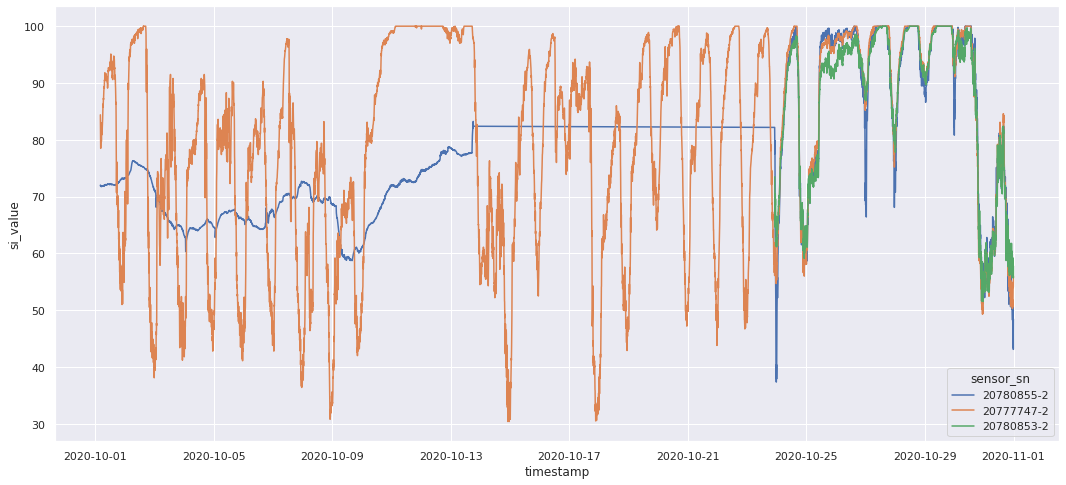

In [20]:
#
# Let's plot the humidity sensors in October
# We use:
# 'timestamp' column for timestamps of the timeseries
# 'si_value' where the sensor values are
# 'data' in the dataframe we generated above for October
# 
# TODO: fix duplicate timestamp entries... which prevents from plotting timeseries properly...
#
sns.lineplot(x='timestamp', y='si_value', hue='sensor_sn', data=df_oct_hum_sense)

Prepared by: LF Murillo (CC-BY) 05-26-2022